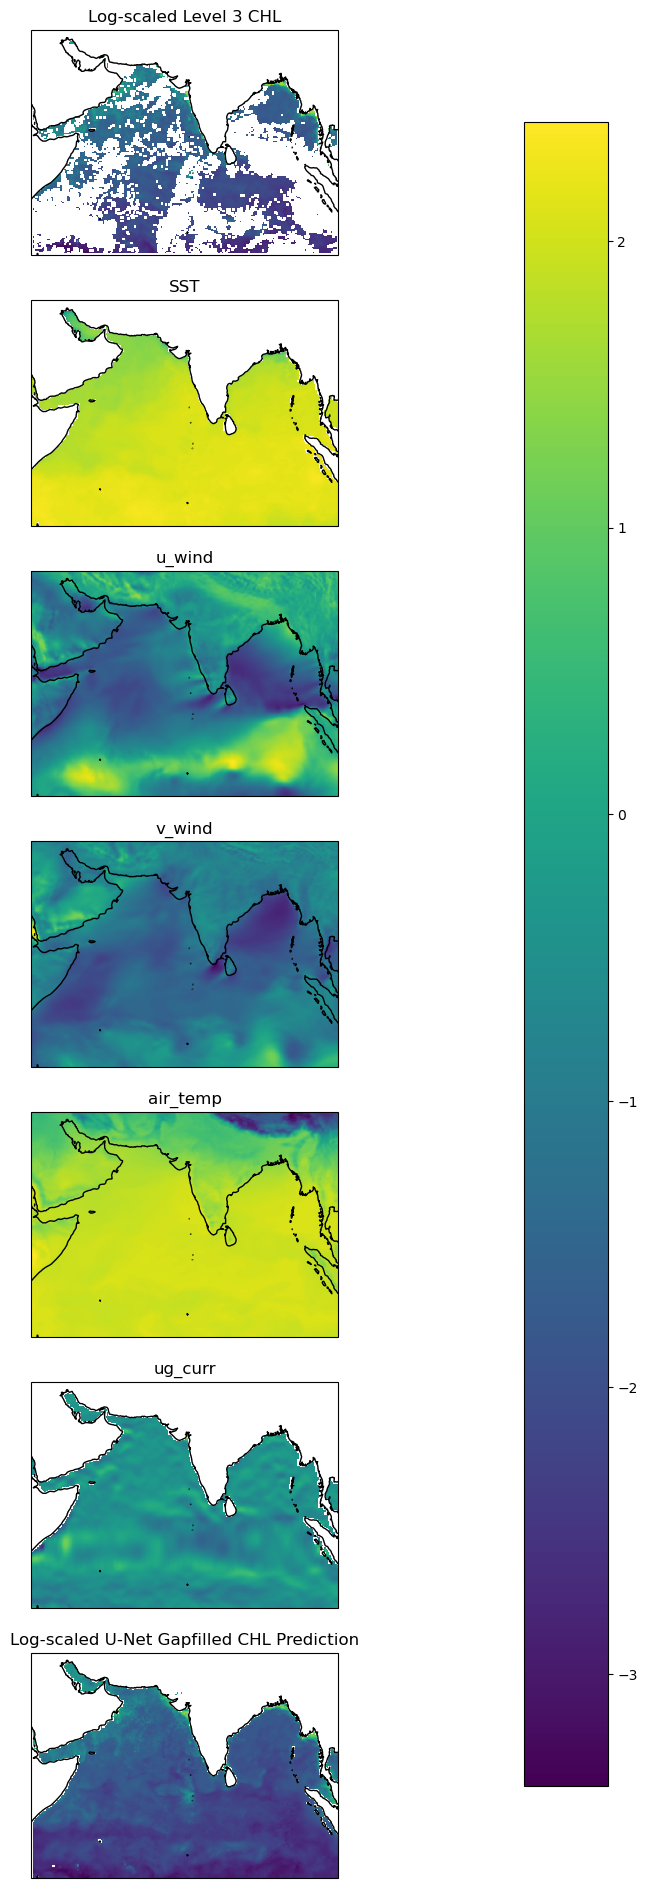

In [42]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the saved Zarr data
zarr_path = "~/shared-public/mind_the_chl_gap/U-Net_with_CHL_pred.zarr"
zarr_ds = xr.open_zarr(zarr_path)["gapfree_pred"]

# Select the date you want to plot
date_to_plot = "2022-01-01"  # Replace with the desired date
zarr_date = zarr_ds.sel(time=date_to_plot)

# Load the Level 3 CHL data
level3_path = "~/shared-public/mind_the_chl_gap/IO.zarr"
level3_ds = xr.open_zarr(level3_path)
level3_chl = level3_ds["CHL_cmes-level3"].sel(time=date_to_plot)
sst = level3_ds["sst"].sel(time=date_to_plot)
u_wind = level3_ds["u_wind"].sel(time=date_to_plot)
v_wind = level3_ds["v_wind"].sel(time=date_to_plot)
air_temp = level3_ds["air_temp"].sel(time=date_to_plot)
ug_curr = level3_ds["ug_curr"].sel(time=date_to_plot)
# Plot the data
fig, axes = plt.subplots(
    nrows=7, ncols=1, figsize=(48, 24), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Plot the log-scaled Level 3 CHL data
ax = axes[0]
level3_chl_log = np.log(level3_chl.where(~np.isnan(level3_chl), np.nan))
im = ax.imshow(
    level3_chl_log,
    vmin=np.nanmin(level3_chl_log),
    vmax=np.nanmax(level3_chl_log),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("Log-scaled Level 3 CHL")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[1]
im = ax.imshow(
    sst,
    vmin=np.nanmin(sst),
    vmax=np.nanmax(sst),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("SST")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[2]
im = ax.imshow(
    u_wind,
    vmin=np.nanmin(u_wind),
    vmax=np.nanmax(u_wind),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("u_wind")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[3]
im = ax.imshow(
    v_wind,
    vmin=np.nanmin(v_wind),
    vmax=np.nanmax(v_wind),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("v_wind")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[4]
im = ax.imshow(
    air_temp,
    vmin=np.nanmin(air_temp),
    vmax=np.nanmax(air_temp),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("air_temp")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[5]
im = ax.imshow(
    ug_curr,
    vmin=np.nanmin(ug_curr),
    vmax=np.nanmax(ug_curr),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("ug_curr")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax = axes[6]
gapfill_chl_log = zarr_date
im = ax.imshow(
    gapfill_chl_log,
    vmin=np.nanmin(gapfill_chl_log),
    vmax=np.nanmax(gapfill_chl_log),
    extent=(42, 101.75, -11.75, 32),
    origin="upper",
    transform=ccrs.PlateCarree(),
)
ax.set_title("Log-scaled U-Net Gapfilled CHL Prediction")
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right", shrink=0.9)
plt.show()

In [85]:
import deepxde as dde
import numpy as np
import xarray as xr

# Load and preprocess the data
zarr_path = "~/shared-public/mind_the_chl_gap/U-Net_with_CHL_pred.zarr"
zarr_ds = xr.open_zarr(zarr_path)["gapfree_pred"]

# Load gappy data (level 3)
level3_path = "~/shared-public/mind_the_chl_gap/IO.zarr"
level3_ds = xr.open_zarr(level3_path).sel(
    lat=slice(zarr_ds.lat.values.max(), zarr_ds.lat.values.min()),
    lon=slice(zarr_ds.lon.values.min(), zarr_ds.lon.values.max()),
)
# Extract latitude and longitude extents to determine height and width
lat = level3_ds.lat.values
lon = level3_ds.lon.values
global_lat = lat
global_lon = lon
height = len(lat)  # Number of latitude points
width = len(lon)  # Number of longitude points
print("Width:", width)

# Set a time slice for the datasets
time_slice = slice("2022-01-01", "2022-12-31")  # Adjust as needed
gappy_data = level3_ds.sel(time=time_slice)

# Variables to include in the branch net
variables = ["CHL_cmes-level3", "sst", "u_wind", "v_wind", "air_temp", "ug_curr"]

# Prepare the data by stacking variables for each time slice
gappy_data_stack = np.stack([gappy_data[var].values for var in variables], axis=1)
dataset_size = gappy_data_stack.shape[0]  # Number of days
print("Dataset Size:", dataset_size)
gappy_data_stack = np.transpose(
    gappy_data_stack, (0, 2, 3, 1)
)  # Shape: (train_size, height, width, num_variables)
print("Gappy Data Stack Shape:", gappy_data_stack.shape)

# Split data into training and testing sets
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Training and testing data
train_ims = gappy_data_stack[:train_size].astype(np.float32)
test_ims = gappy_data_stack[train_size:].astype(np.float32)
print(train_ims.shape)
print(test_ims.shape)

Width: 240
Dataset Size: 365
Gappy Data Stack Shape: (365, 176, 240, 6)
(292, 176, 240, 6)
(73, 176, 240, 6)


In [94]:
# Coordinates extraction for training
coordinates_array_train = np.empty((train_size, 100), dtype=float)
for t_idx in range(train_size):
    chl_data = gappy_data["CHL_cmes-level3"].isel(time=t_idx).values.flatten()
    valid_coords = np.argwhere(~np.isnan(chl_data))
    if len(valid_coords) > 0:
        selected_coords = valid_coords[
            np.random.choice(len(valid_coords), 100, replace=False)
        ]
        coordinates_array_train[t_idx] = selected_coords.flatten()
print(coordinates_array_train.shape)

(292, 100)


In [95]:
train_ims_flat = train_ims.reshape(292, 176 * 240, 6)
test_ims_flat = test_ims.reshape(73, 176 * 240, 6)
train_ims_flat.shape, test_ims_flat.shape, coordinates_array_train.shape

((292, 42240, 6), (73, 42240, 6), (292, 100))

In [113]:
my_inds.shape

(292, 100)

In [111]:
my_inds = coordinates_array_train.astype(int)
result = train_ims_flat[np.arange(292)[:, None], my_inds, :]

In [112]:
result.shape

(292, 100, 6)

In [86]:
def extract_values_at_coordinates(X, coordinates_array_train):
    dataset_size, lat_extent, lon_extent, variables = X.shape
    num_coordinates = coordinates_array_train.shape[1]

    # Initialize an array to store the extracted values
    extracted_values = np.zeros((dataset_size, num_coordinates, variables))

    # Loop through each day in the dataset
    for i in range(dataset_size):
        coords = coordinates_array_train[i]
        for coord in range(num_coordinates):
            lat_coord = coords[coord, 0]
            lon_coord = coords[coord, 1]
            lat_idx = np.where(global_lat == lat_coord)
            lon_idx = np.where(global_lon == lon_coord)
            extracted_values[i, coord] = X[i, lat_idx, lon_idx]

    return extracted_values


X_train_branch = extract_values_at_coordinates(train_ims, coordinates_array_train)
print(X_train_branch.shape)
print(X_train_branch[0, :, 1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [56]:
def extract_values_at_coordinates2(X, coordinates_array_train):
    dataset_size, lat_extent, lon_extent = X.shape
    num_coordinates = coordinates_array_train.shape[1]

    # Initialize an array to store the extracted values
    extracted_values = np.zeros((dataset_size, num_coordinates))

    # Loop through each day in the dataset
    for i in range(dataset_size):
        coords = coordinates_array_train[i]
        lat_coords = coords[:, 0]
        lon_coords = coords[:, 1]

        # Convert lat/lon coordinates to indices
        lat_indices = np.clip(np.round(lat_coords).astype(int), 0, lat_extent - 1)
        lon_indices = np.clip(np.round(lon_coords).astype(int), 0, lon_extent - 1)

        # Extract values from X_train_branch
        for j in range(num_coordinates):
            lat_idx = lat_indices[j]
            lon_idx = lon_indices[j]
            extracted_values[i, j] = X[i, lat_idx, lon_idx]

    return extracted_values

In [53]:
# Coordinates extraction for testing
coordinates_array_test = np.empty((test_size, 100, 2), dtype=float)
for t_idx in range(test_size):
    chl_data = gappy_data["CHL_cmes-level3"].isel(time=t_idx + train_size).values
    valid_coords = np.argwhere(~np.isnan(chl_data))
    if len(valid_coords) > 0:
        selected_coords = valid_coords[
            np.random.choice(len(valid_coords), 100, replace=False)
        ]
        latitudes = lat[selected_coords[:, 0]]
        longitudes = lon[selected_coords[:, 1]]
        coordinates_array_test[t_idx] = np.column_stack((latitudes, longitudes))
print(coordinates_array_test.shape)

(73, 100, 2)


In [54]:
X_test_branch = extract_values_at_coordinates(X_test_branch, coordinates_array_test)
print(X_test_branch.shape)

(73, 100, 6)


In [57]:
# Prepare y_train and y_test
y_train = zarr_ds.sel(time=time_slice).values[:train_size].astype(np.float32)
y_train = extract_values_at_coordinates2(y_train, coordinates_array_train)
y_test = zarr_ds.sel(time=time_slice).values[train_size:].astype(np.float32)
y_test = extract_values_at_coordinates2(y_test, coordinates_array_test)
print(y_train.shape)
print(y_test.shape)

(292, 100)
(73, 100)


In [58]:
# Flatten trunk inputs
X_train_trunk = coordinates_array_train
X_test_trunk = coordinates_array_test
print(X_train_trunk.shape)
print(X_test_trunk.shape)

(292, 100, 2)
(73, 100, 2)


In [68]:
X_train_trunk.shape, y_train.shape

((292, 100, 2), (292, 100))

In [67]:
# DeepONet setup
m = len(variables)  # Number of variables
dim_x = 2  # Latitude and Longitude

net = dde.nn.DeepONet(
    [m, 40, 40],  # Branch net architecture
    [dim_x, 40, 40],  # Trunk net architecture
    "relu",
    "Glorot normal",
)

data = dde.data.Triple(
    X_train=(X_train_branch.astype(np.float32), X_train_trunk.astype(np.float32)),
    y_train=y_train.astype(np.float32),
    X_test=(X_test_branch.astype(np.float32), X_test_trunk.astype(np.float32)),
    y_test=y_test.astype(np.float32),
)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000194 s

Training model...



RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (3) for operand 0 and no ellipsis was given